<a href="https://colab.research.google.com/github/ratimayy/deep/blob/main/MLP2_ex1_3_TensorBoard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Same codes as MLP2_ex1-1 except that there is an additional callback for TensorBoard visualization in this example.

Official code example: https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-29a76f4e-a9e1-e408-f9d4-cd576d552e27)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import os

import numpy as np
print( f"NumPy {np.__version__}\n" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

Pandas 2.1.4

Matplotlib 3.7.1

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
#np.random.seed(1234)
#tf.random.set_seed(5678)

# 2. Prepare the dataset

Load the Boston Housing dataset (http://lib.stat.cmu.edu/datasets/boston) from Keras

In [ ]:
# Load
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

# Inspect
vars = [ ('x_train',x_train), ('y_train',y_train), ('x_test',x_test), ('y_test',y_test) ]
for name,var in vars:
  print(f"{name}: type={type(var)} , shape={var.shape} , dtype={var.dtype}")

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
x_train: type=<class 'numpy.ndarray'> , shape=(404, 13) , dtype=float64
y_train: type=<class 'numpy.ndarray'> , shape=(404,) , dtype=float64
x_test: type=<class 'numpy.ndarray'> , shape=(102, 13) , dtype=float64
y_test: type=<class 'numpy.ndarray'> , shape=(102,) , dtype=float64


(Optional) Preview the train and test sets with pandas' dataframe

In [ ]:
# A function to convert two numpy arrays to a single dataframe
def boston_dataframe(np_x, np_y):
  # Create a dataframe from two numpy arrays
  columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
  df_boston = pd.DataFrame(np_x, columns=columns)   # 13 feature columns
  df_boston['MEDV'] = pd.Series(np_y)   # 1 output column

  return df_boston

# Preview stats regarding both train and test datasets
print('===== PREVIEW: THE TRAIN SET =====')
display( boston_dataframe(x_train, y_train).describe().style.format(precision=2) )
print('\n===== PREVIEW: THE TEST SET =====')
display( boston_dataframe(x_test, y_test).describe().style.format(precision=2) )

===== PREVIEW: THE TRAIN SET =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,3.75,11.48,11.10,0.06,0.56,6.27,69.01,3.74,9.44,405.90,18.48,354.78,12.74,22.40
std,9.24,23.77,6.81,0.24,0.12,0.71,27.94,2.03,8.70,166.37,2.20,94.11,7.25,9.21
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,188.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.13,0.00,0.45,5.87,45.48,2.08,4.00,279.00,17.23,374.67,6.89,16.68
50%,0.27,0.00,9.69,0.00,0.54,6.20,78.50,3.14,5.00,330.00,19.10,391.25,11.39,20.75
75%,3.67,12.50,18.10,0.00,0.63,6.61,94.10,5.12,24.00,666.00,20.20,396.16,17.09,24.80
max,88.98,100.00,27.74,1.00,0.87,8.72,100.00,10.71,24.00,711.00,22.00,396.90,37.97,50.00



===== PREVIEW: THE TEST SET =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,3.09,10.90,11.26,0.10,0.54,6.35,66.85,4.01,9.98,417.50,18.37,364.16,12.31,23.08
std,5.37,21.57,7.08,0.30,0.11,0.67,29.03,2.38,8.77,177.39,2.03,79.14,6.70,9.17
min,0.01,0.00,1.22,0.00,0.39,4.88,6.00,1.47,1.00,187.00,13.00,24.65,1.92,5.60
25%,0.08,0.00,5.46,0.00,0.45,5.97,42.45,2.12,4.00,279.25,17.40,377.69,7.30,18.65
50%,0.23,0.00,9.79,0.00,0.53,6.23,73.75,3.32,5.00,330.00,18.90,392.11,11.06,21.95
75%,3.78,16.25,18.10,0.00,0.61,6.63,92.97,5.28,24.00,666.00,20.20,396.78,15.91,27.08
max,25.05,90.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,21.20,396.90,31.99,50.00


Normalize each feature separately


In [ ]:
# Compute means and SDs from *the train set*
# 'axis' = Axis or axes along which the means are computed. The default is to compute the mean of the flattened array.
mean = x_train.mean(axis=0)   # https://numpy.org/doc/stable/reference/generated/numpy.mean.html
sd = x_train.std(axis=0)      # https://numpy.org/doc/stable/reference/generated/numpy.std.html
print(f"{mean.shape=} , {sd.shape=}\n")

# Normalize 13 features
x_train_norm = ( x_train - mean ) / sd
x_test_norm = ( x_test - mean ) / sd

# Inspect
print('===== PREVIEW: TRAIN SET AFTER NORM =====')
display( boston_dataframe(x_train_norm, y_train).describe().style.format(precision=2) )
print('\n===== PREVIEW: TEST SET AFTER NORM =====')
display( boston_dataframe(x_test_norm, y_test).describe().style.format(precision=2) )

mean.shape=(13,) , sd.shape=(13,)

===== PREVIEW: TRAIN SET AFTER NORM =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,22.40
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,9.21
min,-0.41,-0.48,-1.56,-0.26,-1.47,-3.82,-2.37,-1.29,-0.97,-1.31,-2.67,-3.77,-1.52,5.00
25%,-0.40,-0.48,-0.88,-0.26,-0.89,-0.55,-0.84,-0.82,-0.63,-0.76,-0.57,0.21,-0.81,16.68
50%,-0.38,-0.48,-0.21,-0.26,-0.17,-0.10,0.34,-0.29,-0.51,-0.46,0.28,0.39,-0.19,20.75
75%,-0.01,0.04,1.03,-0.26,0.63,0.48,0.90,0.68,1.68,1.57,0.78,0.44,0.60,24.80
max,9.23,3.73,2.45,3.89,2.68,3.47,1.11,3.44,1.68,1.84,1.60,0.45,3.48,50.00



===== PREVIEW: TEST SET AFTER NORM =====


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,-0.07,-0.02,0.02,0.15,-0.11,0.12,-0.08,0.13,0.06,0.07,-0.05,0.10,-0.06,23.08
std,0.58,0.91,1.04,1.24,0.94,0.95,1.04,1.17,1.01,1.07,0.92,0.84,0.92,9.17
min,-0.40,-0.48,-1.45,-0.26,-1.41,-1.96,-2.26,-1.12,-0.97,-1.32,-2.49,-3.51,-1.49,5.60
25%,-0.40,-0.48,-0.83,-0.26,-0.95,-0.42,-0.95,-0.80,-0.63,-0.76,-0.49,0.24,-0.75,18.65
50%,-0.38,-0.48,-0.19,-0.26,-0.22,-0.05,0.17,-0.20,-0.51,-0.46,0.19,0.40,-0.23,21.95
75%,0.00,0.20,1.03,-0.26,0.44,0.52,0.86,0.76,1.68,1.57,0.78,0.45,0.44,27.08
max,2.31,3.31,2.45,3.89,2.68,3.54,1.11,4.14,1.68,1.84,1.24,0.45,2.66,50.00


For data to be processed by the model, convert them to float32 dtype

In [ ]:
# A conversion function
convert = lambda a: a.astype(np.float32)

# Convert and inspect
vars = [ ('x_train_norm',x_train_norm), ('y_train',y_train), ('x_test_norm',x_test_norm), ('y_test',y_test) ]
for name,var in vars:
  var = convert(var)
  print(f"{name}: type={type(var)} , shape={var.shape} , dtype={var.dtype}")

x_train_norm: type=<class 'numpy.ndarray'> , shape=(404, 13) , dtype=float32
y_train: type=<class 'numpy.ndarray'> , shape=(404,) , dtype=float32
x_test_norm: type=<class 'numpy.ndarray'> , shape=(102, 13) , dtype=float32
y_test: type=<class 'numpy.ndarray'> , shape=(102,) , dtype=float32


# 3. Create the network architecture

In [ ]:
def create_model():
  model = tf.keras.models.Sequential()

  # Input layer
  model.add( tf.keras.Input(shape=(x_train_norm.shape[-1],), name='input') )

  # Hidden layers
  model.add( tf.keras.layers.Dense(8, activation='relu', name='hidden1') )   # use default weight initialization, don't use any regularization
  model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn1') )
  model.add( tf.keras.layers.Dense(16, activation='relu', name='hidden2') )  # use default weight initialization, don't use any regularization
  model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn2') )
  model.add( tf.keras.layers.Dense(8, activation='relu', name='hidden3') )   # use default weight initialization, don't use any regularization
  model.add( tf.keras.layers.Dropout(0.3) )          # drop rate = 30%

  # Output layer: For a regression problem, use a linear activation function (a.k.a., use no activation function)
  model.add( tf.keras.layers.Dense(1, name='output') )

  # Compile with default values for both optimizer and loss
  model.compile( optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'] )

  return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                      │ (None, 8)                   │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 8)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 48 (192.00 B)

# 4. Train the model on train set

In [ ]:
menu = '\n1. Save weights only\n2. Save the full model\nYour choice: '

while True:
  choice = input(menu).strip()
  if choice in ['1', '2']:
    save_weights_only = True if choice=='1' else False
    break



1. Save weights only
2. Save the full model
Your choice: 2


In [ ]:
if save_weights_only:
  checkpoint_filepath = "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.weights.h5"
else:
  checkpoint_filepath = "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=save_weights_only,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

In [ ]:
# Create a new callback for TensorBoard
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard within the notebook
# TensorBoard will be automatically reloaded every 30 seconds
%tensorboard --logdir=logs

In [ ]:
history = model.fit ( x_train_norm, y_train,
                      validation_split=0.2,
                      batch_size=32, epochs=100, verbose=1,
                      callbacks=[model_checkpoint_callback, tensorboard_callback]
                  )

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - loss: 598.4062 - mean_absolute_error: 22.5639 - val_loss: 656.2671 - val_mean_absolute_error: 23.9150
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 607.9457 - mean_absolute_error: 22.7783 - val_loss: 651.0729 - val_mean_absolute_error: 23.8076
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 603.6436 - mean_absolute_error: 22.5501 - val_loss: 645.8878 - val_mean_absolute_error: 23.6985
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 569.5494 - mean_absolute_error: 21.8545 - val_loss: 640.1639 - val_mean_absolute_error: 23.5784
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 621.1028 - mean_absolute_error: 22.8382 - val_loss: 634.5065 - val_mean_absolute_error: 23.4613
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 562.6029 - mean_absolute_error: 21.7972 - val_loss: 628.1528 - val_mean_absolute_error: 23.3287
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 518

In [ ]:
# Inspect the saved files (sorted by modification date, newest first)
!ls -lt

total 4136
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch095_valloss59.51.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch094_valloss61.09.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch093_valloss62.01.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch092_valloss63.55.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch091_valloss64.72.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch090_valloss66.09.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch089_valloss68.01.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch088_valloss69.34.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch087_valloss70.20.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch086_valloss70.51.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch080_valloss70.78.keras
-rw-r--r-- 1 root root 45450 Aug 27 17:31 bestmodel_epoch079_valloss73.01.keras
-rw-r--r-- 1 root root 45450 

In [ ]:
# Check the keys in 'history'
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

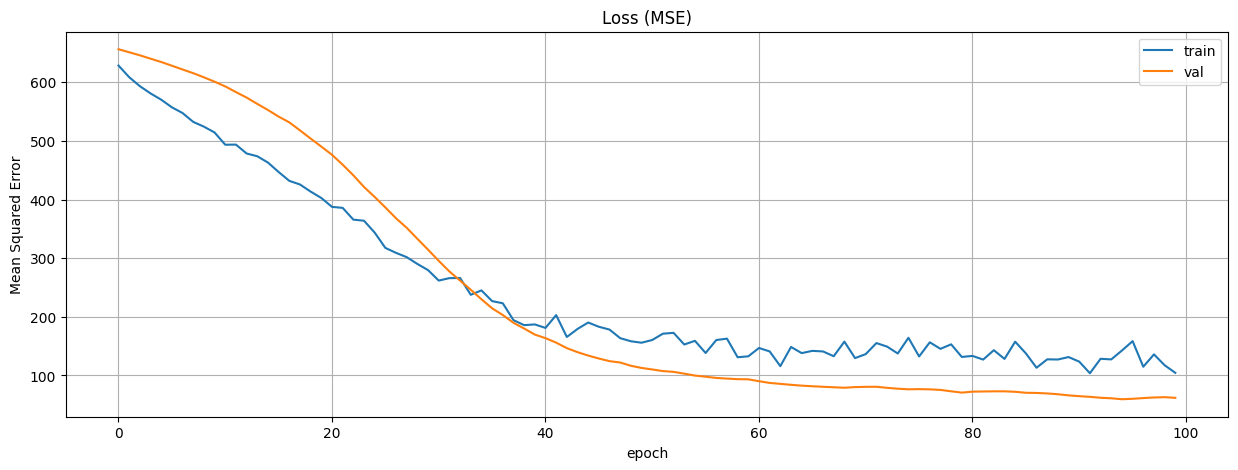

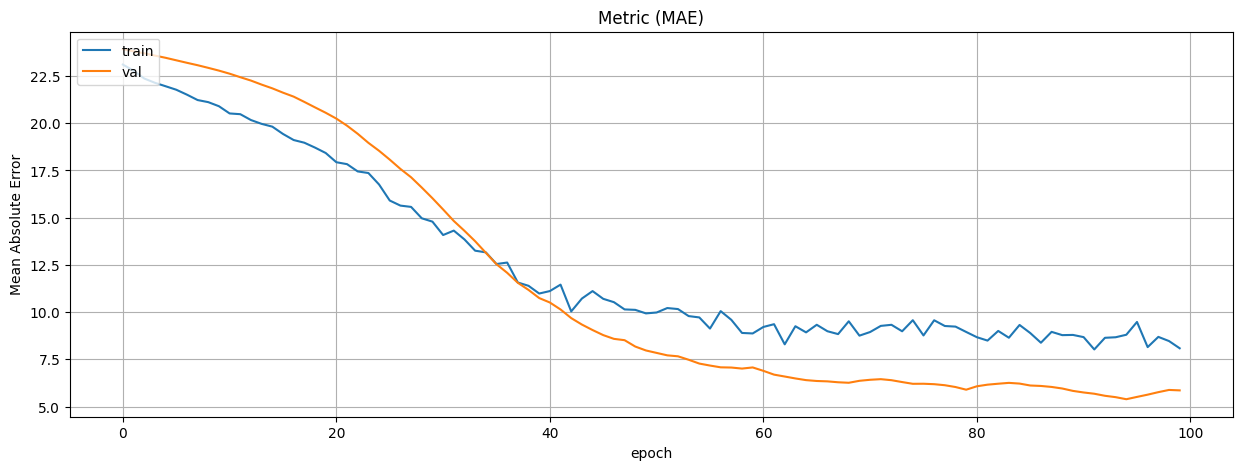

In [ ]:
# Summarize history for MSE loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss (MSE)')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for MAE
plt.figure(figsize=(15,5))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Metric (MAE)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# 5. Evaluate the model on test set

Evaluate the model from the last epoch:

In [ ]:
results = model.evaluate(x_test_norm, y_test, batch_size=50)
print( f"{model.metrics_names} = {results}" )

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 43.7798 - mean_absolute_error: 5.3031
['loss', 'compile_metrics'] = [45.42204666137695, 5.357093334197998]


Load the best model (which may not be the same as the model from the last epoch):

In [ ]:
if save_weights_only:
  # Get the name of the newest .weights.h5 file
  files = [x for x in os.listdir('./') if x.endswith(".weights.h5")]
  newest = max(files , key=os.path.getctime)

  # Load weights of the best model
  best_model = create_model()     # Load the network architecture
  best_model.load_weights(newest) # Load weights
  print(f"Successfully loaded '{newest}' to 'best_model'")
else:
  # Get the name of the newest .keras file
  files = [x for x in os.listdir('./') if x.endswith(".keras")]
  newest = max(files , key=os.path.getctime)

  # Load the best model
  best_model = tf.keras.models.load_model(newest)
  print(f"Successfully loaded '{newest}' to 'best_model'")

Successfully loaded 'bestmodel_epoch095_valloss59.51.keras' to 'best_model'


Evaluate the model from the best epoch:

In [ ]:
# If the model isn't compiled, there will be Error in .evaluate()
results = best_model.evaluate(x_test_norm, y_test, batch_size=50)
print( f"{best_model.metrics_names} = {results}" )

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 38.3628 - mean_absolute_error: 4.7545
['loss', 'compile_metrics'] = [40.305030822753906, 4.815134525299072]


# 6. Inference

In [ ]:
# Predict one row of data
i = 0
y_pred0 = model.predict( x_test_norm[i].reshape(1,-1) )   # Reshape x_test[i] from (n_feature,) to (1, n_feature)
print(f'{y_pred0.shape=}')

# Inspect the result
print(f"x_test[{i}] = {x_test[i]}")
print(f"x_test_norm[{i}] = {x_test_norm[i]}")
print(f"y_test[{i}] = {y_test[i]}")
print(f"y_pred = {y_pred0}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
y_pred0.shape=(1, 1)
x_test[0] = [ 18.0846   0.      18.1      0.       0.679    6.434  100.       1.8347
  24.     666.      20.2     27.25    29.05  ]
x_test_norm[0] = [ 1.55369355 -0.48361547  1.0283258  -0.25683275  1.03838067  0.23545815
  1.11048828 -0.93976936  1.67588577  1.5652875   0.78447637 -3.48459553
  2.25092074]
y_test[0] = 7.2
y_pred = [[8.836973]]


In [ ]:
# Predict many rows of data at once
i,j = 2,21
y_preds = model.predict( x_test_norm[i:j] )
print(f'{y_preds.shape=}')

# Inspect the results
results = boston_dataframe(x_test[i:j], y_test)         # Create the test dataframe of 14 columns (13 features + 1 output)
results.rename(columns={'MEDV':'y_true'}, inplace=True) # Rename the last column from 'MEDV' to 'y_true'
results['y_pred'] = pd.Series(y_preds.squeeze())        # Append the prediction results as the rightmost column
results['Abs. Error'] = (results['y_true'] - results['y_pred']).abs()  # Compute Abs. Error betweeon 'y_true' and 'y_pred'
                                                                       # Append Abs. Error values as a new column

results.style.format(precision=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
y_preds.shape=(19, 1)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y_true,y_pred,Abs. Error
0,0.05,0.00,5.19,0.00,0.52,5.99,45.40,4.81,5.00,224.00,20.20,396.90,9.74,7.20,17.76,10.56
1,1.27,0.00,19.58,1.00,0.60,6.25,92.60,1.80,5.00,403.00,14.70,338.92,5.50,18.80,18.53,0.27
2,0.07,0.00,4.49,0.00,0.45,6.12,56.80,3.75,3.00,247.00,18.50,395.15,8.44,19.00,17.69,1.31
3,0.28,0.00,9.69,0.00,0.58,5.93,42.60,2.38,6.00,391.00,19.20,396.90,13.59,27.00,16.06,10.94
4,0.03,55.00,3.78,0.00,0.48,6.87,28.10,6.47,5.00,370.00,17.60,387.97,4.61,22.20,23.31,1.11
5,0.04,25.00,4.86,0.00,0.43,6.17,46.70,5.40,4.00,281.00,19.00,390.64,7.51,24.50,16.07,8.43
6,0.09,0.00,25.65,0.00,0.58,5.96,92.90,2.09,2.00,188.00,19.10,378.09,17.93,31.20,17.17,14.03
7,3.57,0.00,18.10,0.00,0.58,6.44,75.00,2.90,24.00,666.00,20.20,393.37,14.36,22.90,20.94,1.96
8,0.23,0.00,8.56,0.00,0.52,6.41,85.40,2.71,5.00,384.00,20.90,70.80,10.63,20.50,17.83,2.67
9,1.35,0.00,8.14,0.00,0.54,6.07,100.00,4.17,4.00,307.00,21.00,376.73,13.04,23.20,14.98,8.22
